**IMPORTANT** - running on the full Preston observatory uses about 12GB of memory as of 10/14/2019

In [1]:
import csv
import random
from enum import Enum

from nquads import NQuads
from prestongraph import *

### Get provenance log

On a large preston.acis.ufl.edu observatory it can take a while to run ```preston ls```, so we store its output at a temporary location
```shell
preston ls --remote http://preston.acis.ufl.edu > tmp/nquads
```

### Index the provenance logs

In [3]:
%%time

import sys
import io

#path = "../preston.acis.ufl.edu/tmp/nquads"
path = "../preston.acis.ufl.edu/tmp/nquads"
fullIndex = Index()

sys.stdin = io.FileIO(path)

# Parse the provenance log into a list of n-quads
for line in sys.stdin:
    nQuads = NQuads.Parse(str(line))
    for nQuad in nQuads:
        fullIndex.Ingest(nQuad)

del sys
del io

CPU times: user 1h 9min 41s, sys: 33min 5s, total: 1h 42min 47s
Wall time: 1h 43min 2s


In [9]:
print("{:,}".format(len(fullIndex.nodes)), "nodes")

3,681,269 nodes


In [5]:
for x in fullIndex.verbs: print(x)

http://purl.org/dc/terms/description
http://www.w3.org/ns/prov#qualifiedGeneration
http://www.w3.org/ns/prov#wasGeneratedBy
http://www.w3.org/ns/prov#used
http://purl.org/dc/terms/bibliographicCitation
http://www.w3.org/ns/prov#generatedAtTime
http://purl.org/pav/previousVersion
http://purl.org/pav/hasVersion
http://www.w3.org/1999/02/22-rdf-syntax-ns#seeAlso
http://purl.org/dc/elements/1.1/format
http://www.w3.org/ns/prov#startedAtTime
http://www.w3.org/ns/prov#usedBy
http://www.w3.org/ns/prov#wasStartedBy
http://www.w3.org/ns/prov#hadMember
http://www.w3.org/ns/prov#activity
http://www.w3.org/1999/02/22-rdf-syntax-ns#type
http://www.w3.org/ns/prov#wasAssociatedWith
http://purl.org/pav/createdBy


In [3]:
def PrintNodeSubTree(node, maxDepth=1, root=True):
    if root:
        for x in node.inwardTriples:
            print(x)

    if maxDepth > 0:
        for x in node.outwardTriples:
            print(x)
            PrintNodeSubTree(x.object, maxDepth - 1, False)

### Get crawl UUIDs and sort them by date

In [46]:
class CrawlMeta:
    def __init__(self, position, date):
        self.position = position
        self.date = date

In [49]:
crawlDates = []
for triple in fullIndex.verbLookup["http://www.w3.org/ns/prov#startedAtTime"].triples:
    crawlDates.append((triple.subject, triple.object))
numCrawls = len(crawlDates)

crawlDates.sort(key=lambda x: x[1])

# Assign some helpful metadata to each crawl
crawlMetaLookup = dict()
for i, crawlDate in enumerate(crawlDates):
    # Contaminate crawl nodes with their chronological position in the preston history
    crawlMeta = CrawlMeta(
        position=i,
        date=crawlDate[1]
    )

    crawlMetaLookup[crawlDate[0]] = crawlMeta

    print("%s\t%s\t%d" % (crawlDate[0], crawlMeta.date, crawlMeta.position))

1d711945-d205-4663-b534-6d706b8b77b6	2018-09-04T07:29:11.130Z	0
4e540f45-d7a1-40d6-a2b8-f623f1c1d566	2018-09-04T20:47:09.581Z	1
f496b900-679d-4470-99d4-9d4901f828d0	2018-09-04T20:49:40.349Z	2
e1d0c6ea-f402-4186-affd-bc10806b822f	2018-09-05T07:28:51.929Z	3
90fa570e-579f-4e98-b060-f5886019f0b6	2018-09-05T07:36:06.462Z	4
27c0f6fa-a74f-41ac-b9c4-2f596ea940a6	2018-09-07T19:02:50.655Z	5
d8952f30-4b8f-4c10-9867-b04b2807fe89	2018-09-15T22:05:29.715Z	6
f55b0d70-3b1e-4012-9109-7497481e2af5	2018-09-15T22:06:06.646Z	7
4655fd3f-3df6-4c30-b356-a02499058339	2018-09-15T22:06:44.636Z	8
e9ae04ba-79bf-4e84-8617-e155bf1bb9cf	2018-09-22T05:07:01.664Z	9
6ee12a54-7315-4181-9b67-37861ed41153	2018-09-22T05:30:30.164Z	10
e871efcd-c2f9-4e8e-ac3a-bc45943c3e65	2018-10-01T04:59:15.301Z	11
091c9d67-2f58-45fc-83dc-5656c848ba33	2018-10-07T17:16:39.644Z	12
76401ae1-4d1e-4175-a4c3-bc45139bcc35	2018-10-15T22:20:58.497Z	13
6e151310-45b7-469d-94fd-88d471175e7b	2018-10-22T18:46:37.188Z	14
70040298-643c-45c7-adb8-521a26f4a20

### Build a history for each URL

In [30]:
def Peek(nativeSet):
    item = nativeSet.pop()
    nativeSet.add(item)
    return item

In [56]:
class UrlLifetime:
    def __init__(self, numCrawls):
        self.statuses = [Status.UNKNOWN] * numCrawls
        self.contents = [None] * numCrawls

### Collect the contents seen over the course of each URL's lifetime

In [132]:
%%time

urlLifetimes = dict()

for x in fullIndex.verbLookup["http://www.w3.org/ns/prov#qualifiedGeneration"].triples:
    qualGen = x.object

    # Get content
    contentTriple = (qualGen.inwardTriples & fullIndex.verbLookup["http://www.w3.org/ns/prov#qualifiedGeneration"].triples).pop()
    content = contentTriple.subject

    # Get URL
    urlTriple = (qualGen.outwardTriples & fullIndex.verbLookup["http://www.w3.org/ns/prov#used"].triples).pop()
    url = urlTriple.object

    # Get crawl
    crawlTriple = (qualGen.outwardTriples & fullIndex.verbLookup["http://www.w3.org/ns/prov#activity"].triples).pop()
    crawl = crawlTriple.object

    # Fill in URL lifetime data
    if url in urlLifetimes:
        lifetime = urlLifetimes[url]
    else:
        lifetime = UrlLifetime(numCrawls)
        urlLifetimes[url] = lifetime

    crawlMeta = crawlMetaLookup[crawl]
    lifetime.contents[crawlMeta.position] = content

CPU times: user 15.7 s, sys: 7.34 ms, total: 15.7 s
Wall time: 15.9 s


In [163]:
print("{:,}".format(len(urlLifetimes)), "urls")

75,337 urls


### Assign a status for each stage of each URL's lifetime

In [135]:
class Status(Enum):
    UNKNOWN             = 0    # Did not check for content
    FIRST_CONTENT       = 1    # Returned content for the first time
    SAME_CONTENT        = 2    # Returned the same content as the last successful query
    CHANGED_CONTENT     = 3    # Returned new content
    OLD_CONTENT         = 4    # Returned previously seen content that is different from the previous successful data
    BECAME_UNRESOLVED   = 5    # Failed to return content after a successful query
    STILL_UNRESOLVED    = 6    # Failed to return content again
    ERROR               = 7    # Returned malformed content

There's some ambiguity in the status of a URL's first query; we make some arbitrary, totally unfounded assumptions:
* If unresolved, consider it BECAME_UNRESOLVED rather than STILL_UNRESOLVED
* If resolved, consider it FIRST_CONTENT rather than SAME_CONTENT, OLD_CONTENT, or CHANGED_CONTENT

In [261]:
%%time

for url, lifetime in urlLifetimes.items():
    wasAlive = True
    mostRecentContent = None
    for i, content in enumerate(lifetime.contents):

        if content:
            if "https://deeplinker.bio/.well-known/genid/" in str(content):
        # Became unresolved
                if wasAlive and mostRecentContent:
                    status = Status.BECAME_UNRESOLVED
                    wasAlive = False

        # Still unresolved
                else:
                    status = Status.STILL_UNRESOLVED

        # First content
            elif mostRecentContent == None:
                status = Status.FIRST_CONTENT
                mostRecentContent = content

        # Same content
            elif content == mostRecentContent:
                status = Status.SAME_CONTENT

            else:
        # Old content
                if content in lifetime.contents[0:i]:
                    status = Status.OLD_CONTENT

        # Changed content
                else:
                    status = Status.CHANGED_CONTENT
                mostRecentContent = content

        # Unknown
        else:
            status = Status.UNKNOWN

        lifetime.statuses[i] = status

CPU times: user 15.3 s, sys: 593 ms, total: 15.9 s
Wall time: 24.4 s


In [164]:
print("Lifetime for %s\n" % url)
print("\n".join(["%d:\t%s\t%s" % (i, lifetime.statuses[i], lifetime.contents[i]) for i in range(numCrawls)]))

Lifetime for http://tb.plazi.org/GgServer/dwca/FFE0FFDFC14600674E4EFF9DFFF6FF8D.zip

0:	Status.FIRST_CONTENT	hash://sha256/d18549fce64f19e9a6f4d0a6c94b49d2f6d3d17c8f84fba7f42fe4b6d0df2c71
1:	Status.SAME_CONTENT	hash://sha256/d18549fce64f19e9a6f4d0a6c94b49d2f6d3d17c8f84fba7f42fe4b6d0df2c71
2:	Status.SAME_CONTENT	hash://sha256/d18549fce64f19e9a6f4d0a6c94b49d2f6d3d17c8f84fba7f42fe4b6d0df2c71
3:	Status.UNKNOWN	None
4:	Status.UNKNOWN	None
5:	Status.SAME_CONTENT	hash://sha256/d18549fce64f19e9a6f4d0a6c94b49d2f6d3d17c8f84fba7f42fe4b6d0df2c71
6:	Status.UNKNOWN	None
7:	Status.UNKNOWN	None
8:	Status.SAME_CONTENT	hash://sha256/d18549fce64f19e9a6f4d0a6c94b49d2f6d3d17c8f84fba7f42fe4b6d0df2c71
9:	Status.UNKNOWN	None
10:	Status.SAME_CONTENT	hash://sha256/d18549fce64f19e9a6f4d0a6c94b49d2f6d3d17c8f84fba7f42fe4b6d0df2c71
11:	Status.SAME_CONTENT	hash://sha256/d18549fce64f19e9a6f4d0a6c94b49d2f6d3d17c8f84fba7f42fe4b6d0df2c71
12:	Status.SAME_CONTENT	hash://sha256/d18549fce64f19e9a6f4d0a6c94b49d2f6d3d17c8f84f

## Build figures
These should probably be colorless (i.e. use black and white textures and dotted lines)

### New, modified, lost content per crawl

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from itertools import cycle, islice

%matplotlib inline

In [269]:
col_hex = {
    "blue"      : "#1f77b4",
    "orange"    : "#ff7f0e",
    "green"     : "#2ca02c",
    "red"       : "#d62728",
    "purple"    : "#9467bd",
    "brown"     : "#8c564b",
    "pink"      : "#e377c2",
    "gray"      : "#7f7f7f",
    "yellow"    : "#bcbd22",
    "teal"      : "#17becf",
    
    "bright green"  : "#00ff00",
    "bright red"    : "#ff0000",
    "green yellow"  : "#9ACD32",
    "olive"         : "#808000"
}

# Using X.name since using X wasn't working (can't use enums as keys?)
# status_color = { k : col_hex[v] for k, v in {
#     Status.UNKNOWN.name             : "gray",
#     Status.FIRST_CONTENT.name       : "bright green",
#     Status.SAME_CONTENT.name        : "green",
#     Status.CHANGED_CONTENT.name     : "yellow",
#     Status.BECAME_UNRESOLVED.name   : "bright red",
#     Status.STILL_UNRESOLVED.name    : "red",
#     Status.ERROR.name               : "purple",
                                    
# }.items()}

fig_df = status_crawl_totals_df[[
    Status.SAME_CONTENT,
    Status.FIRST_CONTENT,
    Status.OLD_CONTENT,
    Status.CHANGED_CONTENT,
    Status.STILL_UNRESOLVED,
    Status.BECAME_UNRESOLVED,
    Status.UNKNOWN,
    Status.ERROR
]]

status_colors = {
    Status.UNKNOWN             : "gray",
    Status.FIRST_CONTENT       : "bright green",
    Status.SAME_CONTENT        : "green",
    Status.CHANGED_CONTENT     : "yellow",
    Status.OLD_CONTENT         : "olive",
    Status.BECAME_UNRESOLVED   : "bright red",
    Status.STILL_UNRESOLVED    : "red",
    Status.ERROR               : "purple",
}

status_color_map = list(islice(cycle([col_hex[status_colors[x]] for x in fig_df.columns]), None, 256))

In [260]:
list(urlLifetimes.values())[41111].statuses

[<Status.FIRST_CONTENT: 1>,
 <Status.SAME_CONTENT: 2>,
 <Status.UNKNOWN: 0>,
 <Status.UNKNOWN: 0>,
 <Status.UNKNOWN: 0>,
 <Status.SAME_CONTENT: 2>,
 <Status.UNKNOWN: 0>,
 <Status.UNKNOWN: 0>,
 <Status.SAME_CONTENT: 2>,
 <Status.UNKNOWN: 0>,
 <Status.UNKNOWN: 0>,
 <Status.SAME_CONTENT: 2>,
 <Status.SAME_CONTENT: 2>,
 <Status.SAME_CONTENT: 2>,
 <Status.SAME_CONTENT: 2>,
 <Status.SAME_CONTENT: 2>,
 <Status.SAME_CONTENT: 2>,
 <Status.SAME_CONTENT: 2>,
 <Status.SAME_CONTENT: 2>,
 <Status.SAME_CONTENT: 2>,
 <Status.SAME_CONTENT: 2>,
 <Status.SAME_CONTENT: 2>,
 <Status.CHANGED_CONTENT: 3>,
 <Status.SAME_CONTENT: 2>,
 <Status.SAME_CONTENT: 2>,
 <Status.SAME_CONTENT: 2>,
 <Status.SAME_CONTENT: 2>,
 <Status.CHANGED_CONTENT: 3>,
 <Status.SAME_CONTENT: 2>,
 <Status.SAME_CONTENT: 2>,
 <Status.UNKNOWN: 0>,
 <Status.BECAME_UNRESOLVED: 5>,
 <Status.UNKNOWN: 0>,
 <Status.UNKNOWN: 0>,
 <Status.UNKNOWN: 0>,
 <Status.UNKNOWN: 0>,
 <Status.UNKNOWN: 0>,
 <Status.UNKNOWN: 0>,
 <Status.UNKNOWN: 0>]

In [270]:
%%time

crawl_status_totals_df = pd.DataFrame(
    index   = [x for x in Status],
    columns = [datetime.datetime.strptime(str(x[1]), "%Y-%m-%dT%H:%M:%S.%fZ") for x in crawlDates],
    data    = 0,
    dtype   = int
)

for _, lifetime in urlLifetimes.items():
    for i, status in enumerate(lifetime.statuses):
        crawl_status_totals_df.iloc[status.value][i] += 1

CPU times: user 11min 45s, sys: 988 ms, total: 11min 46s
Wall time: 11min 52s


In [160]:
crawl_status_totals_df

,2018-09-04 07:29:11.130000,2018-09-04 20:47:09.581000,2018-09-04 20:49:40.349000,2018-09-05 07:28:51.929000,2018-09-05 07:36:06.462000,2018-09-07 19:02:50.655000,2018-09-15 22:05:29.715000,2018-09-15 22:06:06.646000,2018-09-15 22:06:44.636000,2018-09-22 05:07:01.664000,...,2019-02-04 16:33:24.359000,2019-03-01 20:37:34.877000,2019-03-31 23:33:18.478000,2019-05-01 03:57:18.530000,2019-06-01 10:43:38.196000,2019-07-01 21:41:36.023000,2019-08-01 02:27:40.507000,2019-09-01 09:34:33.505000,2019-10-14 12:44:15.391000,2019-10-14 12:44:23.237000
Status.UNKNOWN,26841,26841,60146,75166,75143,35121,75319,75332,25837,75325,...,22955,58121,21015,20177,19649,19097,28446,19681,75337,75337
Status.FIRST_CONTENT,46426,48,2,68,21,932,0,0,228,0,...,4056,363,2010,15372,750,697,709,580,0,0
Status.SAME_CONTENT,0,45605,13424,28,146,33613,11,5,37040,7,...,36998,9812,19974,27071,39879,42826,40106,42102,0,0
Status.CHANGED_CONTENT,0,672,676,52,4,3705,4,0,10182,3,...,10062,2723,11516,11231,11346,11260,4814,11576,0,0
Status.OLD_CONTENT,0,0,0,0,0,0,0,0,7,0,...,158,3432,4985,0,1,27,0,2,0,0
Status.BECAME_UNRESOLVED,2070,2171,1089,23,23,1966,3,0,2043,2,...,1108,886,15837,1486,3712,1430,1262,1396,0,0
Status.STILL_UNRESOLVED,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Status.ERROR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [167]:
status_crawl_totals_df = crawl_status_totals_df.transpose()

In [168]:
# # Get total URL status counts for each crawl
# status_counts_df = (time_labeled_df
#     .apply(lambda x: x.value_counts()).fillna(0)
#     .transpose())[[
#         Status.SAME_CONTENT,
#         Status.NEW_CONTENT,
#         Status.UNRESOLVED,
#         Status.UNKNOWN
#     ]]

# status_counts_df

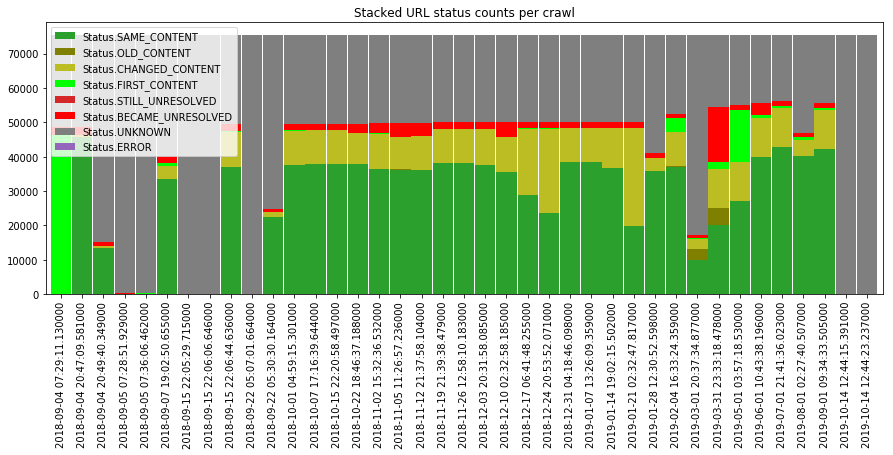

In [265]:
fig_df.plot(kind="bar", stacked=True, width=.96, color=status_color_map, figsize=(15, 5),
                      title="Stacked URL status counts per crawl");

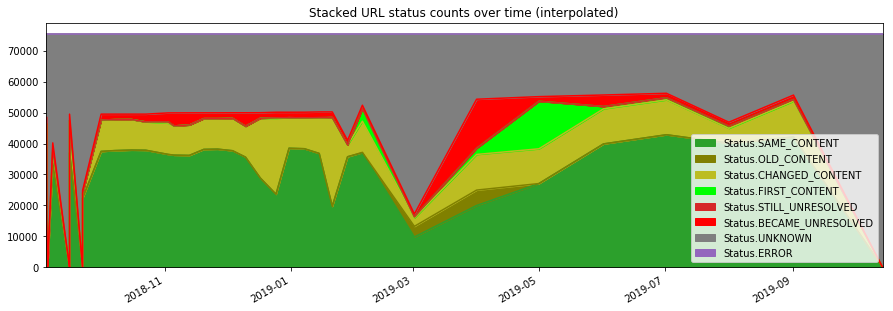

In [266]:
fig_df.plot(kind="area", stacked=True, color=status_color_map, figsize=(15, 5),
                      title="Stacked URL status counts over time (interpolated)");

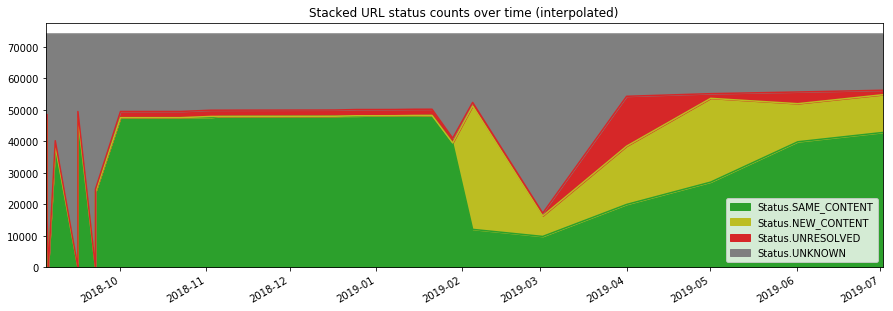

In [25]:
status_counts_df.plot(kind="area", stacked=True, color=status_color_map, figsize=(15, 5),
                      title="Stacked URL status counts over time (interpolated)");

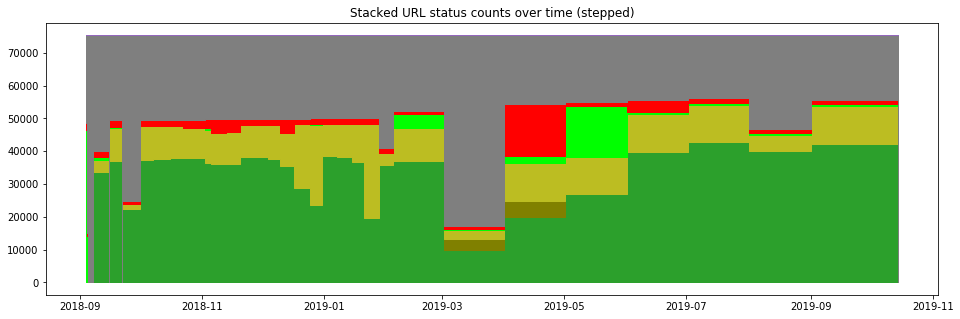

In [267]:
# Make figure
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(111, title="Stacked URL status counts over time (stepped)")

# Fill in space between lines
x = fig_df.index.append(pd.Index([datetime.datetime.now()]))
y1 = pd.Series({ q : 0 for q in x })

columns = fig_df.columns
n = len(columns)
for i in range(0, n):
    y2 = y1 + fig_df[columns[i]] + 0
    ax.fill_between(x, y1, y2, step="post", color=status_color_map[i])
    y1 = y2

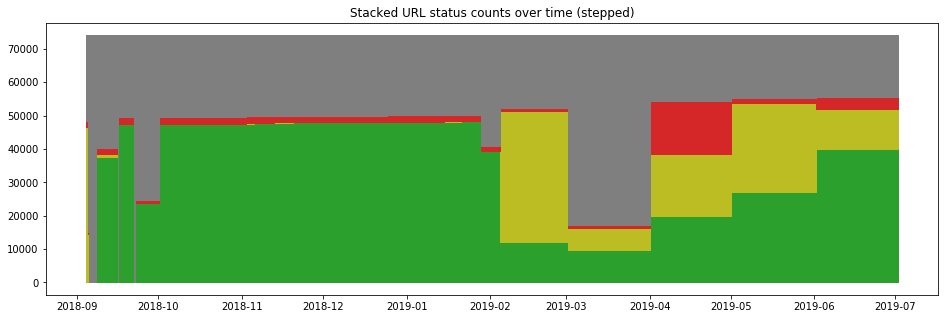

In [26]:
fig_df = status_counts_df

# Make figure
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(111, title="Stacked URL status counts over time (stepped)")

# Fill in space between lines
x = fig_df.index.append(pd.Index([datetime.datetime.now()]))
y1 = pd.Series({ q : 0 for q in x })

columns = status_counts_df.columns
n = len(columns)
for i in range(0, n):
    y2 = y1 + fig_df[columns[i]] + 0
    ax.fill_between(x, y1, y2, step="post", color=status_color_map[i])
    y1 = y2

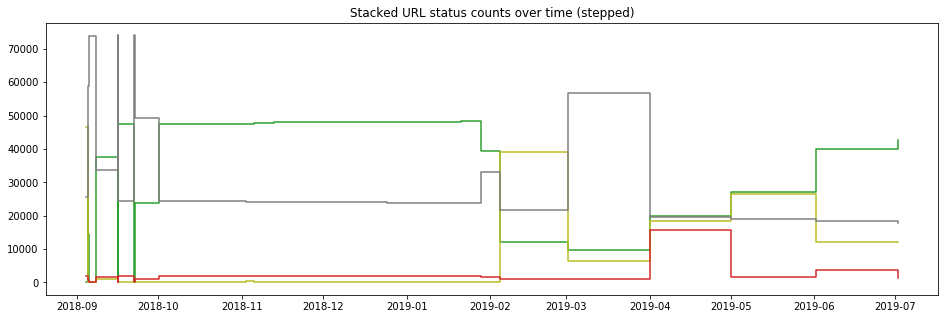

In [27]:
fig_df = status_counts_df

# Make figure
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(111, title="Stacked URL status counts over time (stepped)")

# Draw stepped lines
x = fig_df.index
for status in fig_df.columns:
    y = fig_df[status]
    plt.step(x, y, where="post", color=status_color[status.name])

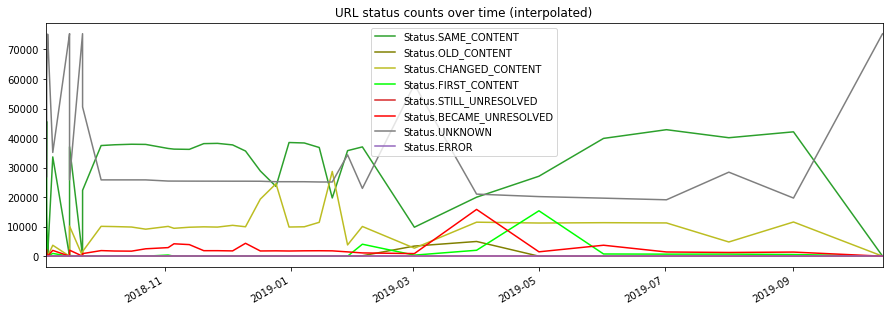

In [268]:
ax = fig_df.plot(kind="line", stacked=False, color=status_color_map, figsize=(15, 5),
                 title="URL status counts over time (interpolated)")

In [29]:
[x for x in enumerate(history_urls) if history_urls[x[0]] == "http://plazi.cs.umb.edu/GgServer/dwca/0014FFE9FF94FFA3126AFFF0FFA2D93F.zip"]

[(19206,
  'http://plazi.cs.umb.edu/GgServer/dwca/0014FFE9FF94FFA3126AFFF0FFA2D93F.zip')]

In [30]:
url_status_histories[19206]

[<Status.NEW_CONTENT: 2>,
 <Status.SAME_CONTENT: 3>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.SAME_CONTENT: 3>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.SAME_CONTENT: 3>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.NEW_CONTENT: 2>,
 <Status.UNKNOWN: 1>,
 <Status.UNRESOLVED: 4>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>]

### Count number of URLs that have had updates

In [31]:
history = url_status_histories[0]

In [32]:
print("Total number of URLs:", len(url_status_histories))

Total number of URLs: 74050


In [33]:
count = 0
for history in url_status_histories:
    count += (len([x for x in history if x == Status.NEW_CONTENT]) > 1)
print("Number of updated URLs:", count)

Number of updated URLs: 37675


In [43]:
[x for x in url]

[<Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.NEW_CONTENT: 2>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.UNRESOLVED: 4>,
 <Status.UNRESOLVED: 4>,
 <Status.UNRESOLVED: 4>]

In [58]:
for i, url in enumerate(url_status_histories):
    if len(url) == len([x for x in url if (x == Status.NEW_CONTENT or x == Status.SAME_CONTENT)]):
        print("yay!", i, url_contents[i][0])

yay! 33800 http://danbif.au.dk/ipt/eml.do?r=ds38
yay! 36679 http://data.canadensys.net/ipt/archive.do?r=cbu-specimens
yay! 44605 http://digir.pangaea.de/dwca/?id=112855


In [61]:
url_status_histories[44605]

[<Status.NEW_CONTENT: 2>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.NEW_CONTENT: 2>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>]